<a href="https://colab.research.google.com/github/AishaEvering/IsItToxic/blob/main/IsItToxic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

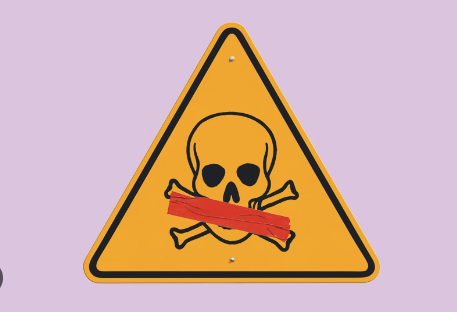

### Project Overview

While the internet offers countless benefits, it can also be a breeding ground for toxicity from anonymous keyboard warriors. It’s a fact that people can sometimes become overly aggressive or harmful online, whether intentionally or not. To address this issue, I am developing a deep learning model designed to assess the toxicity of comments.

This model will categorize comments into several types, including generally toxic, severe toxic, obscene, threatening, insulting, or identity hate (such as racism). I will be using the [Jigsaw Toxic Comment Classification Challenge dataset](https://www.kaggle.com/datasets/julian3833/jigsaw-toxic-comment-classification-challenge) from Kaggle, which offers a diverse collection of comments to train and evaluate the model’s performance.


### Key Objectives

- **Develop and Train Neural Network Model**: Build and train a sequential neural network model using TensorFlow.
- **Handle Multi-Label Classification**: Implement techniques for multi-label classification to predict various levels of toxicity.
- **Leverage a Diverse Dataset**: Utilize the [Jigsaw Toxic Comment Classification Challenge dataset](https://www.kaggle.com/datasets/julian3833/jigsaw-toxic-comment-classification-challenge) from Kaggle to ensure a broad and representative range of comments.

### Project Details

1. **Dataset**: The [Jigsaw Toxic Comment Classification Challenge dataset](https://www.kaggle.com/datasets/julian3833/jigsaw-toxic-comment-classification-challenge) from Kaggle offers a comprehensive collection of comments, categorized into labels such as toxic, severe toxic, obscene, threatening, insulting, and identity hate.
   
2. **Task**: Develop a model to classify comments into multiple categories, including:
   - **Toxic**: Is the comment considered toxic?
   - **Severe Toxic**:  Is the comment extremely toxic?
   - **Obscene**: Is the comment obscene?
   - **Threatening**: Is the comment threatening someone?
   - **Insulting**: Is the comment insulting someone?
   - **Identity Hate**: Is the comment exhibiting identity-based hate (e.g., racism)?

3. **Approach**:
  - **Preprocess Data**: Tokenize the comments to convert them into features that the model can work with.
  - **Build Model**: Construct a model that includes an embedding layer and an LSTM layer.
    - The embedding layer captures the semantic information of each word.
    - The LSTM layer, wrapped in a Bidirectional layer, captures context from both past and future parts of the sequence (sentence).
  - **Model Training**: Train and optimize the neural network model for multi-label classification.
  - **Evaluation**: Assess the model's performance using appropriate multi-label metrics, including precision, recall, and accuracy.


# Import Dependencies and Bring in Data

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

## Load Data

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Toxicity/train.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
df.iloc[7]['comment_text']

"Your vandalism to the Matt Shirvington article has been reverted.  Please don't do it again, or you will be banned."

In [4]:
df[df.columns[2:]].iloc[7]

,7
toxic,0
severe_toxic,0
obscene,0
threat,0
insult,0
identity_hate,0


In [220]:
from tensorflow.keras.layers import TextVectorization

In [6]:
X = df["comment_text"] # get features
y = df[df.columns[2:]].values # labels
X.shape, y.shape

((159571,), (159571, 6))

In [7]:
X.head(3)

,comment_text
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)"
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."


In [8]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [9]:
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

## Pre-process Data

In [10]:
# Vocabulary size and number of words in a sequence.
vocab_size = 200_000
sequence_length = 1800

vectorizer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

vectorizer.adapt(X.values)

In [11]:
# changing words into number, yay
vectorize_text = vectorizer(X.values)
vectorize_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [12]:
# creating tensorflow data pipeline
#MCSHBAP - map, cache, shuffle, batch, prefetch
dataset = tf.data.Dataset.from_tensor_slices((vectorize_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160_000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps prevent bottlenecks

In [13]:
# split the dataset batches
ds_length = len(dataset)
train = dataset.take(int(ds_length * .7)) # 70% for training data
val = dataset.skip(int(ds_length * .7)).take(int(ds_length * .2)) # 20% for validation data
test = dataset.skip(int(ds_length * .9)).take(int(ds_length * .1)) # 10% for testing data
len(train), len(val), len(test)

(6981, 1994, 997)

# Create Sequential Model

In [206]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding, Input

In [159]:
def create_and_compile_model():
  embedding_dim = 32

  model = Sequential([
      Input(shape=(sequence_length,)),
      Embedding(vocab_size + 1, embedding_dim, name="embedding"),
      Bidirectional(LSTM(32, activation='tanh')),
      Dense(128, activation='relu'),
      Dense(256, activation='relu'),
      Dense(128, activation='relu'),
      Dense(6, activation='sigmoid', name="output"),
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  return model

model = create_and_compile_model()
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 1800, 32)            │       6,400,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 64)                  │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,491,686 (24.76 MB)

 Trainable params: 6,491,686 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

# Train

In [160]:
# train model
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 723s 103ms/step - accuracy: 0.9395 - loss: 0.0826 - val_accuracy: 0.9947 - val_loss: 0.0463
Epoch 2/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 719s 103ms/step - accuracy: 0.9874 - loss: 0.0459 - val_accuracy: 0.9942 - val_loss: 0.0409
Epoch 3/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 720s 103ms/step - accuracy: 0.9865 - loss: 0.0409 - val_accuracy: 0.9946 - val_loss: 0.0363
Epoch 4/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 720s 103ms/step - accuracy: 0.9938 - loss: 0.0361 - val_accuracy: 0.9945 - val_loss: 0.0342
Epoch 5/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 720s 103ms/step - accuracy: 0.9931 - loss: 0.0322 - val_accuracy: 0.9935 - val_loss: 0.0299
Epoch 6/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 719s 103ms/step - accuracy: 0.9923 - loss: 0.0293 - val_accuracy: 0.9935 - val_loss: 0.0264
Epoch 7/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 711s 102ms/step - accuracy: 0.9915 - loss: 0.0273 - val_accuracy: 0.9929 - val_loss: 0.0238
Epoch 8/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 698s 100ms/step - ac

In [161]:
import matplotlib.pyplot as plt

In [162]:
history.history

{'accuracy': [0.9757287502288818,
  0.990286111831665,
  0.9818077683448792,
  0.9935628771781921,
  0.99298095703125,
  0.9922109842300415,
  0.987054169178009,
  0.9899817109107971,
  0.9711627960205078,
  0.958870530128479],
 'loss': [0.061858952045440674,
  0.0455976203083992,
  0.04065639153122902,
  0.03666331246495247,
  0.03305601701140404,
  0.02976037934422493,
  0.027586592361330986,
  0.024647781625390053,
  0.02240005135536194,
  0.020247971639037132],
 'val_accuracy': [0.9946715235710144,
  0.9941700100898743,
  0.9945774674415588,
  0.9945148229598999,
  0.9935117959976196,
  0.9935431480407715,
  0.992853581905365,
  0.9918505549430847,
  0.9897818565368652,
  0.9921640157699585],
 'val_loss': [0.046330828219652176,
  0.040870301425457,
  0.03632137551903725,
  0.0341658778488636,
  0.02988424524664879,
  0.02638695202767849,
  0.023791639134287834,
  0.021214373409748077,
  0.018994776532053947,
  0.017325732856988907]}

<Figure size 800x500 with 0 Axes>

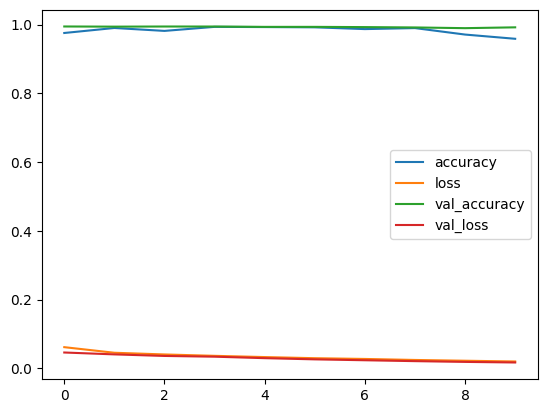

In [163]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# Make Predictions

In [164]:
input_text = vectorizer("You freaking suck!")

In [165]:
res = model.predict(np.expand_dims(input_text, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


In [166]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [167]:
res

array([[0.9977937 , 0.3183723 , 0.9892151 , 0.01136189, 0.9288277 ,
        0.08615915]], dtype=float32)

In [168]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [169]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [170]:
batch_y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

# Evaluate Model

In [171]:
from tensorflow.python.keras.metrics import Precision, Recall, CategoricalAccuracy

In [172]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [173]:
for batch in test.as_numpy_iterator():
  X_true, y_true = batch
  yhat = model.predict(X_true)

  y_true = y_true.flatten()
  yhat = yhat.flatten()

  pre.update_state(y_true, yhat)
  re.update_state(y_true, yhat)
  acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━

In [174]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9300265908241272, Recall:0.910404622554779, Accuracy:0.49548646807670593


#Test and Gradio

In [175]:
!pip install gradio jinja2

In [176]:
import tensorflow as tf
import gradio as gr

In [120]:
model.save('toxicity.keras')

In [177]:
input_str = vectorizer("Die!")

In [178]:
res = model.predict(np.expand_dims(input_str,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


In [179]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [180]:
res

array([[0.73783255, 0.04109791, 0.03538562, 0.34500787, 0.05907975,
        0.04293496]], dtype=float32)

In [229]:
from timeit import default_timer as timer

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

def score_comment(comment):
  start_time = timer()

  vectorized_comment = vectorizer([comment])
  results = model.predict(vectorized_comment)

  text= ""

  for idx, col in enumerate(class_names):
    text += '{}: {}\n'.format(col, results[0][idx] > 0.5)

  pred_time = round(timer() - start_time, 4)

  return text, pred_time

In [230]:
title = 'Is It Toxic?'
description = 'A sequential neural network model designed to predict the toxicity level of a comment.'
article = 'Created at [IsItToxic](https://github.com/AishaEvering/IsItToxic).'
examples=['You are a good person.', "You suck as a person.",  "Shut Up!"]

interface = gr.Interface(fn=score_comment,
                         inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
                         outputs=['text', gr.Number(label="Prediction time (seconds)")],
                         title=title,
                         examples=examples,
                         description=description,
                         article=article)

In [231]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://51516319d453d7eb2e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# Deploy to Hugging Face

Creaet Demo Folder

In [199]:
import shutil
from pathlib import Path

toxic_demo_path = Path('demo/toxic_demo/')

if toxic_demo_path.exists():
  shutil.rmtree(toxic_demo_path)

toxic_demo_path.mkdir(parents=True, exist_ok=True)

!ls demo/toxic_demo/

Move Model to Demo Folder

In [200]:
model = 'toxicity.h5'

model_destination = toxic_demo_path / model

try:
  print(f'[INFO] Attempting to mode {model} to {model_destination}')

  # Move the model
  shutil.move(src=model, dst=model_destination)

  print(f'[INFO] Model move complete.')
except:
  print(f'[INFO] No model found at {model}, perhaps its already been moved?')
  print(f'[INFO] Model exists at {model_destination} : {model_destination.exists()}')

[INFO] Attempting to mode toxicity.h5 to demo/toxic_demo/toxicity.h5
[INFO] Model move complete.


Save Vectorizer

In [216]:
import json

# get the configuration
config = vectorizer.get_config()

# Save the configuration to a JSON file
with open(toxic_demo_path / 'vectorizer_config.json', 'w') as f:
    json.dump(config, f)

Create vectorizer.py

In [228]:
%%writefile demo/toxic_demo/vectorizer.py

import json
from tensorflow.keras.layers import TextVectorization

def create_vectorizer():

  with open('vectorizer_config.json', 'r') as f:
      config = json.load(f)

  # recreate the TextVectorization layer from the configuration
  return TextVectorization.from_config(config)

Overwriting demo/toxic_demo/vectorizer.py


Create model.py

In [232]:
%%writefile demo/toxic_demo/app.py

import json
import tensorflow as tf
import gradio as gr
import vectorizer
from timeit import default_timer as timer


class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# load modeal
model = tf.keras.models.load_model('toxicity.h5')

vectorizer = vectorizer.create_vectorizer()

def score_comment(comment):
  start_time = timer()

  vectorized_comment = vectorizer([comment])
  results = model.predict(vectorized_comment)

  text= ""

  for idx, col in enumerate(class_names):
    text += '{}: {}\n'.format(col, results[0][idx] > 0.5)

  pred_time = round(timer() - start_time, 4)

  return text, pred_time

# create Gradio demo
import gradio as gr

title = 'Is It Toxic?'
description = 'A sequential neural network model designed to predict the toxicity level of a comment.'
article = 'Created at [IsItToxic](https://github.com/AishaEvering/IsItToxic).'
examples=["If you don't stop, I'll make sure you regret it.", "Shut up, you absolute moron.",  "Wow, you are good!"]

demo = gr.Interface(fn=score_comment,
                         inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
                         outputs=['text', gr.Number(label="Prediction time (seconds)")],
                         title=title,
                         examples=examples,
                         description=description,
                         article=article)

# Launch the demo!!!!
demo.launch(share=True)

Writing demo/toxic_demo/app.py


Create Requirements File

In [235]:
print(tf.__version__)

2.17.0


In [236]:
%%writefile demo/toxic_demo/requirements.txt
tensorflow==2.17.0
gradio==4.36.1
json==2.0.9

Writing demo/toxic_demo/requirements.txt


Zip the Demo Folder Up

In [237]:
# Change into the toxic_demp directory and then zip it from the inside
!cd demo/toxic_demo && zip -r ../toxic_demo.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 51%)
  adding: requirements.txt (stored 0%)
  adding: toxicity.h5 (deflated 8%)
  adding: vectorizer_config.json (deflated 45%)
  adding: vectorizer.py (deflated 41%)


Download App Zip File

In [238]:
# Download
try:
  from google.colab import files
  files.download('demo/toxic_demo.zip')
except:
  print(f"Not running in Google Colab, can't use google.colab.files.download(), \
  please download toxic_demo.zip manually.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>